# Clasificación utilizando LightGBM (LGBM) (Core)


## Objetivo

Implementar un pipeline completo de machine learning para un problema de clasificación utilizando LightGBM (LGBM). Se hará especial énfasis en el Análisis Exploratorio de Datos (EDA), preprocesamiento, entrenamiento del modelo y optimización de hiperparámetros.

### Dataset:

https://github.com/shrikant-temburwar/Loan-Prediction-Dataset/blob/master/train.csv



**Descripción del Dataset:**
El dataset de predicción de préstamos contiene información sobre solicitantes de préstamos, como sus ingresos, historial crediticio y otras características personales. El objetivo es predecir si un solicitante será aprobado para un préstamo basándose en estos factores.

# Parte 1: Carga y Exploración Inicial de Datos



In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 1) Carga del Dataset:
- Cargar el dataset desde Kaggle.



In [14]:
import pandas as pd

# URL del dataset en GitHub
url = "https://raw.githubusercontent.com/shrikant-temburwar/Loan-Prediction-Dataset/master/train.csv"

# Cargar el dataset usando pandas
try:
    df = pd.read_csv(url)
    print("Dataset cargado exitosamente.")
    # Mostrar las primeras filas del DataFrame para una vista previa
    print(df.head())
except Exception as e:
    print(f"Error al cargar el dataset: {e}")

Dataset cargado exitosamente.
    Loan_ID Gender Married Dependents     Education Self_Employed  \
0  LP001002   Male      No          0      Graduate            No   
1  LP001003   Male     Yes          1      Graduate            No   
2  LP001005   Male     Yes          0      Graduate           Yes   
3  LP001006   Male     Yes          0  Not Graduate            No   
4  LP001008   Male      No          0      Graduate            No   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             5849                0.0         NaN             360.0   
1             4583             1508.0       128.0             360.0   
2             3000                0.0        66.0             360.0   
3             2583             2358.0       120.0             360.0   
4             6000                0.0       141.0             360.0   

   Credit_History Property_Area Loan_Status  
0             1.0         Urban           Y  
1             1.0         Rural     

In [15]:
df.shape

(614, 13)

## 2) Exploración Inicial:
- Revisar la estructura del dataset.
- Describir las variables y su distribución.
- Identificar y documentar valores faltantes y outliers.

In [16]:
print(df.info())
print("\n")
print(df.describe(include='all').round(2))
print("\n")
print("Valores nulos:")
print(df.isnull().sum() * 100 / len(df))
print("\n")
print("Valores duplicados:")
print(df.duplicated().sum())
print("\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB
None


         Loan_ID Gender Married Dependents Education Self_Employed  \
count        614    601     611    

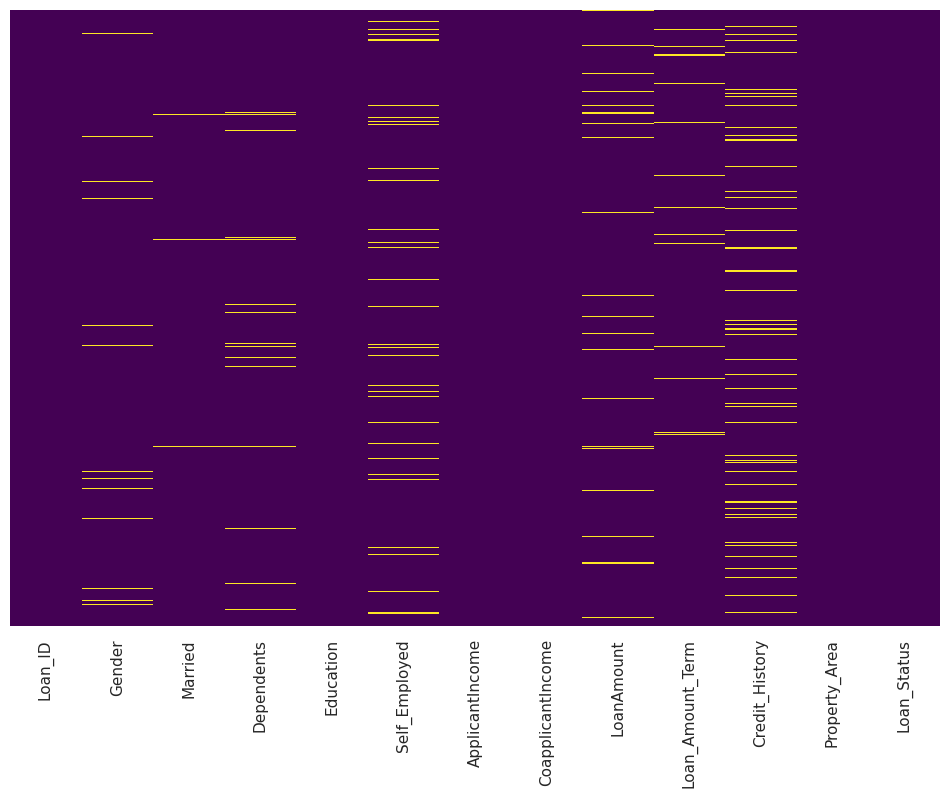

In [28]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap="viridis")
plt.show()

In [29]:
nan_rows = df[df.isnull().any(axis=1)]
print(nan_rows)


      Loan_ID  Gender Married Dependents     Education Self_Employed  \
0    LP001002    Male      No          0      Graduate            No   
11   LP001027    Male     Yes          2      Graduate           NaN   
16   LP001034    Male      No          1  Not Graduate            No   
19   LP001041    Male     Yes          0      Graduate           NaN   
23   LP001050     NaN     Yes          2  Not Graduate            No   
..        ...     ...     ...        ...           ...           ...   
592  LP002933     NaN      No         3+      Graduate           Yes   
597  LP002943    Male      No        NaN      Graduate            No   
600  LP002949  Female      No         3+      Graduate           NaN   
601  LP002950    Male     Yes          0  Not Graduate           NaN   
605  LP002960    Male     Yes          0  Not Graduate            No   

     ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0               5849                0.0         NaN           

In [30]:
nan_counts_per_row = df.isnull().sum(axis=1)
print(nan_counts_per_row)


0      1
1      0
2      0
3      0
4      0
      ..
609    0
610    0
611    0
612    0
613    0
Length: 614, dtype: int64


In [31]:
all_nan_rows = df[df.isnull().all(axis=1)]
print(all_nan_rows)


Empty DataFrame
Columns: [Loan_ID, Gender, Married, Dependents, Education, Self_Employed, ApplicantIncome, CoapplicantIncome, LoanAmount, Loan_Amount_Term, Credit_History, Property_Area, Loan_Status]
Index: []


In [17]:
def uniq (df):
    df=pd.DataFrame([[i,df[i].unique(),df[i].dtype,len(df[i].unique())]for i in df.columns],columns=['feature','val','types','len']).set_index('feature')
    return df

uniq(df)

,val,types,len
feature,,,
Loan_ID,"[LP001002, LP001003, LP001005, LP001006, LP001...",object,614
Gender,"[Male, Female, nan]",object,3
Married,"[No, Yes, nan]",object,3
Dependents,"[0, 1, 2, 3+, nan]",object,5
Education,"[Graduate, Not Graduate]",object,2
Self_Employed,"[No, Yes, nan]",object,3
ApplicantIncome,"[5849, 4583, 3000, 2583, 6000, 5417, 2333, 303...",int64,505
CoapplicantIncome,"[0.0, 1508.0, 2358.0, 4196.0, 1516.0, 2504.0, ...",float64,287
LoanAmount,"[nan, 128.0, 66.0, 120.0, 141.0, 267.0, 95.0, ...",float64,204


In [18]:
def explore_null_columns(df):

    for col in df.columns:
        if df[col].isnull().any():
            print(f"Columna: {col}")
            print(f"Valores únicos (incluyendo nulos):\n{df[col].value_counts(dropna=False)}")
            print("-" * 20)

explore_null_columns(df)

Columna: Gender
Valores únicos (incluyendo nulos):
Gender
Male      489
Female    112
NaN        13
Name: count, dtype: int64
--------------------
Columna: Married
Valores únicos (incluyendo nulos):
Married
Yes    398
No     213
NaN      3
Name: count, dtype: int64
--------------------
Columna: Dependents
Valores únicos (incluyendo nulos):
Dependents
0      345
1      102
2      101
3+      51
NaN     15
Name: count, dtype: int64
--------------------
Columna: Self_Employed
Valores únicos (incluyendo nulos):
Self_Employed
No     500
Yes     82
NaN     32
Name: count, dtype: int64
--------------------
Columna: LoanAmount
Valores únicos (incluyendo nulos):
LoanAmount
NaN      22
120.0    20
110.0    17
100.0    15
160.0    12
         ..
240.0     1
214.0     1
59.0      1
166.0     1
253.0     1
Name: count, Length: 204, dtype: int64
--------------------
Columna: Loan_Amount_Term
Valores únicos (incluyendo nulos):
Loan_Amount_Term
360.0    512
180.0     44
480.0     15
NaN       14
300.0

In [19]:
def unique_and_count(df, column_name):

  if column_name not in df.columns:
    print(f"Error: Column '{column_name}' not found in DataFrame.")
    return None

  unique_values = df[column_name].unique()
  value_counts = df[column_name].value_counts()

  result = {
      'unique_values': unique_values,
      'value_counts': value_counts
  }

  return result

unique_and_count(df, 'Loan_Status')

{'unique_values': array(['Y', 'N'], dtype=object),
 'value_counts': Loan_Status
 Y    422
 N    192
 Name: count, dtype: int64}

In [20]:
def unique_and_count_p(df, column_name):

  if column_name not in df.columns:
    print(f"Error: Column '{column_name}' not found in DataFrame.")
    return None

  unique_values = df[column_name].unique()
  value_counts = df[column_name].value_counts(normalize=True) * 100 # Calculate percentages

  result = {
      'unique_values': unique_values,
      'value_counts': value_counts
  }

  return result

loan_status_analysis = unique_and_count_p(df, 'Loan_Status')

if loan_status_analysis:
    print(loan_status_analysis['value_counts'])

Loan_Status
Y    68.729642
N    31.270358
Name: proportion, dtype: float64


In [21]:
# Detectar outliers en variables numéricas (no está incluida selección de columnas numéricas)
def outliers_IQR(df):
    for col in df:
        Q1 = df[col].quantile(0.25)  # First quartile
        Q3 = df[col].quantile(0.75)  # Third quartile
        IQR = Q3 - Q1               # Interquartile range

        # Definir los límites inferior y superior de los valores atípicos
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Identificar outliers
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        print(f"\n🚩 Outliers detected in {col}: {outliers.shape[0]}")

        # Opcional: Remover outliers
        # df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

# ***IQR (Rango Intercuartílico)*** medida de dispersión estadística que ayuda a ID valores atípicos (outliers)

outliers_IQR(df.select_dtypes(include=['int', 'float']))


🚩 Outliers detected in ApplicantIncome: 50

🚩 Outliers detected in CoapplicantIncome: 18

🚩 Outliers detected in LoanAmount: 39

🚩 Outliers detected in Loan_Amount_Term: 88

🚩 Outliers detected in Credit_History: 89


### Análisis:
-	Se realizó la carga correcta y se verificó conforme las dimensiones del dataset de la página de GitHub

-	En la exploración inicial se nota que hay presencia de datos nulos en el dataset, que de las 13 columnas hay 5 columnas numéricas y el resto categóricas, y la variable objetivo es categórica “Loan_Status” y tiene un desbalanceo de clases Y (sí) con el 68.73% y  N (no) con el 31.27%

-	Loan_ID se puede eliminar, no hay valores duplicados y los nulos debieron de verificiarse bastante, dado que, de 614 registros 134 son nulos, un 21,8% que  considero es bastante para eliminar todos los nulos, pero la imputación dadas las “condiciones” y falta de conocimiento del rubro no lo considero viable, además, lo más adecuado sería realizar revisión detallada a todos los registros.

-	Además hay outliers que se deben tratar.


# Parte 2: Análisis Exploratorio de Datos (EDA)



## 1) Análisis Estadístico Descriptivo:
- Calcular estadísticas descriptivas básicas (media, mediana, desviación estándar, etc.).
- Analizar la distribución de las variables categóricas.


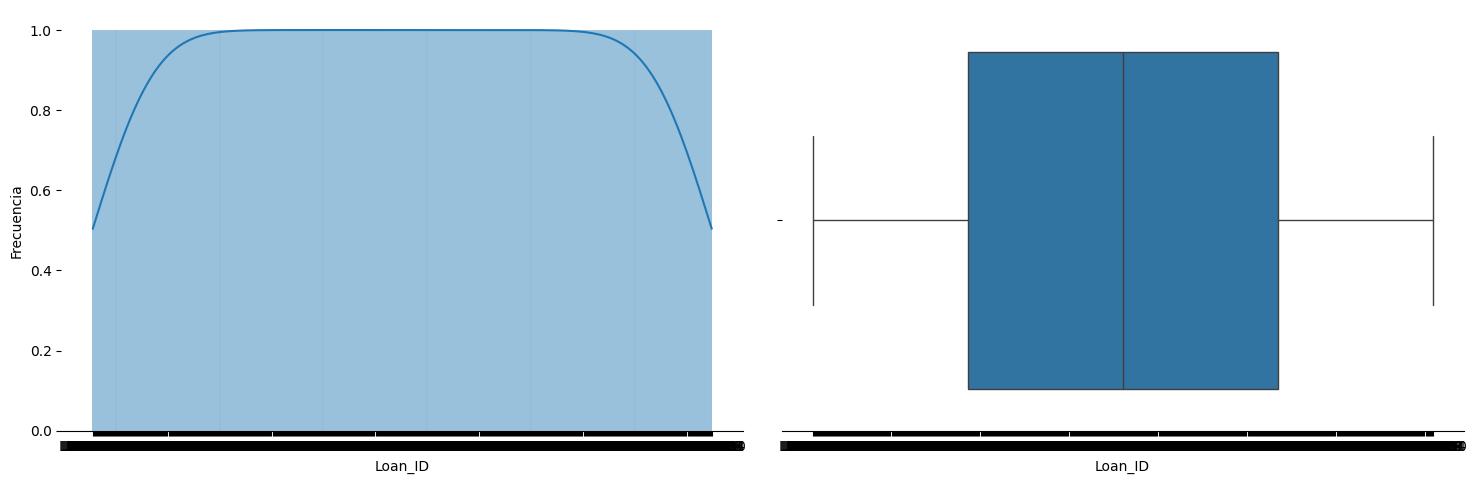

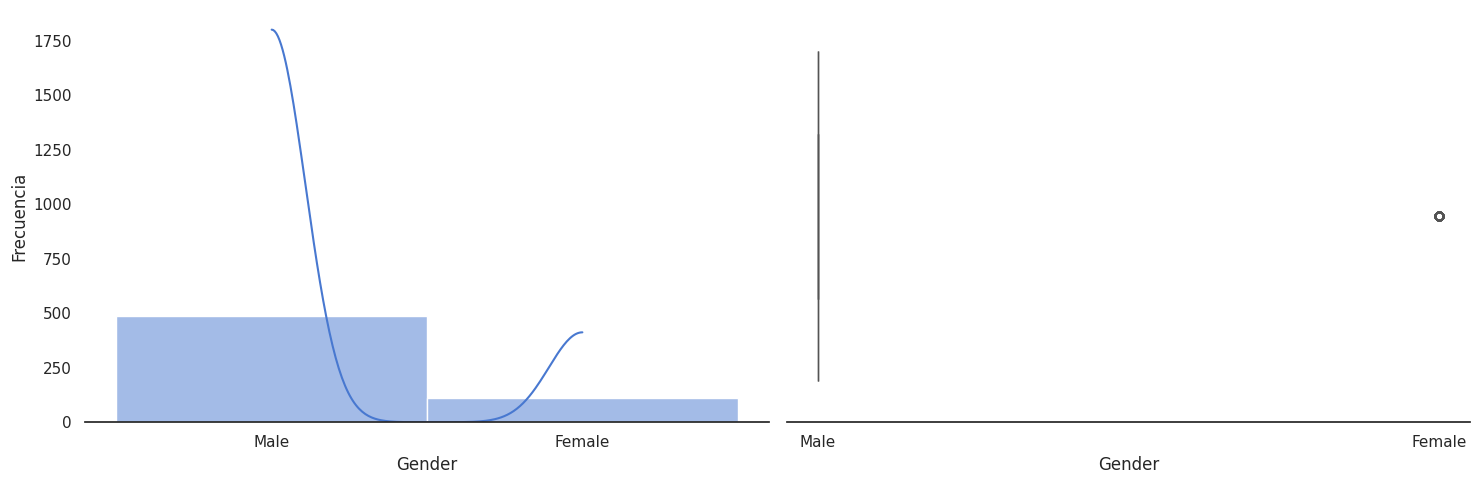

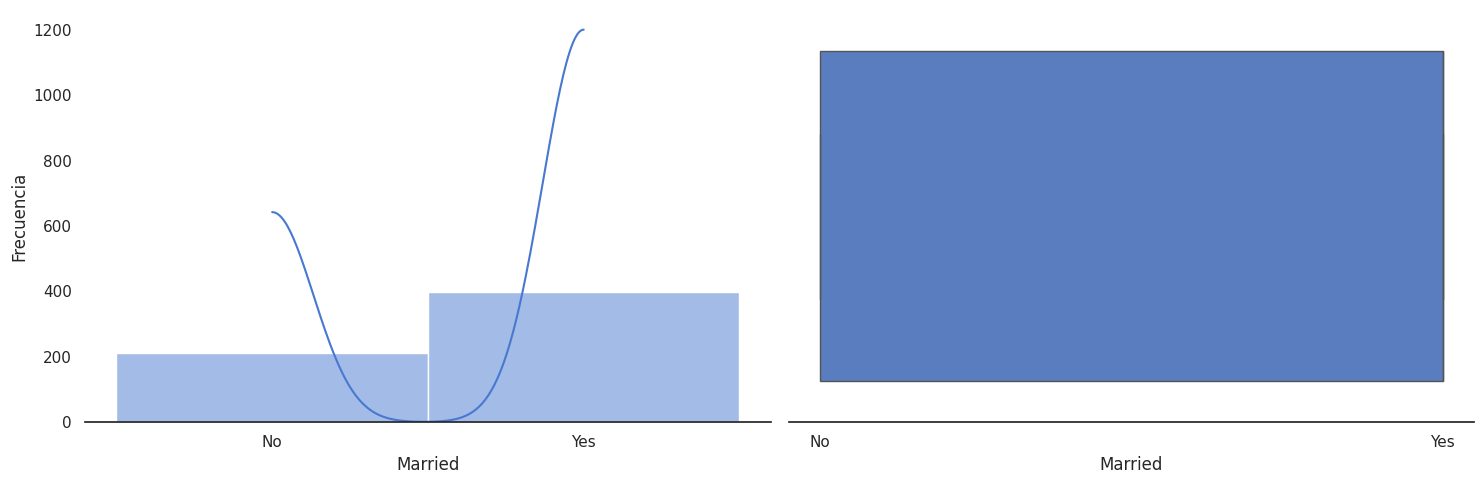

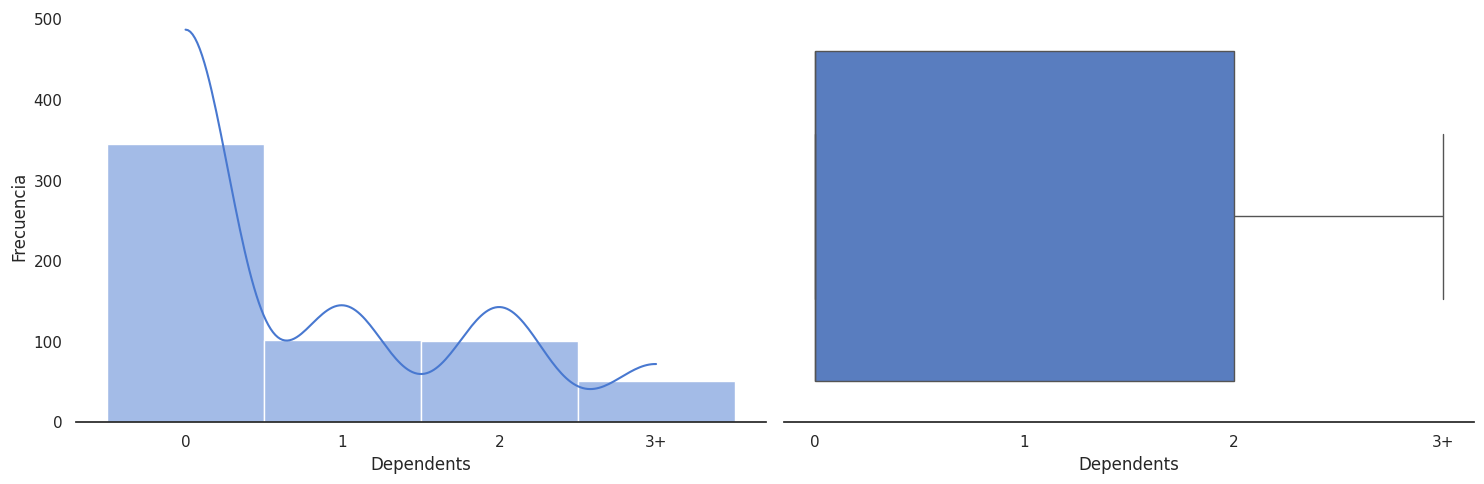

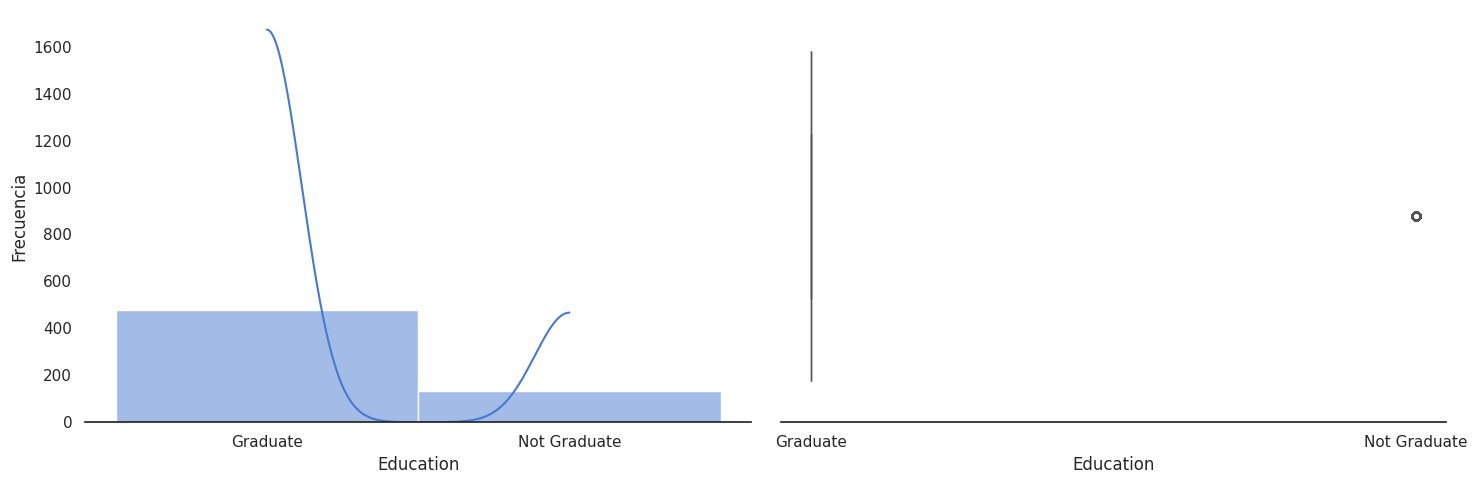

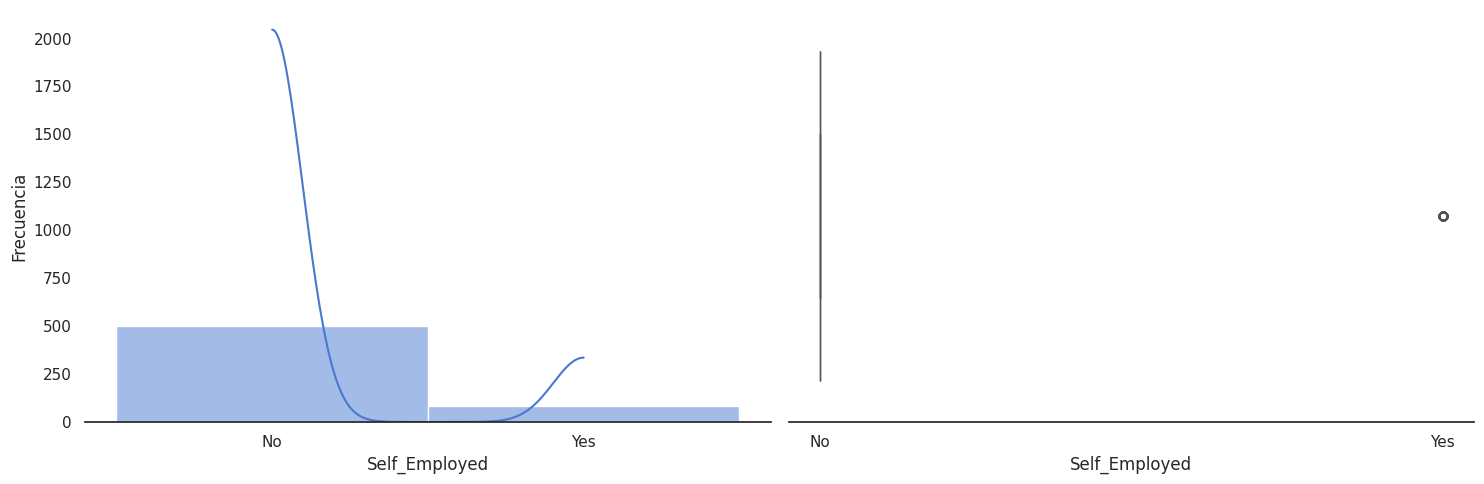

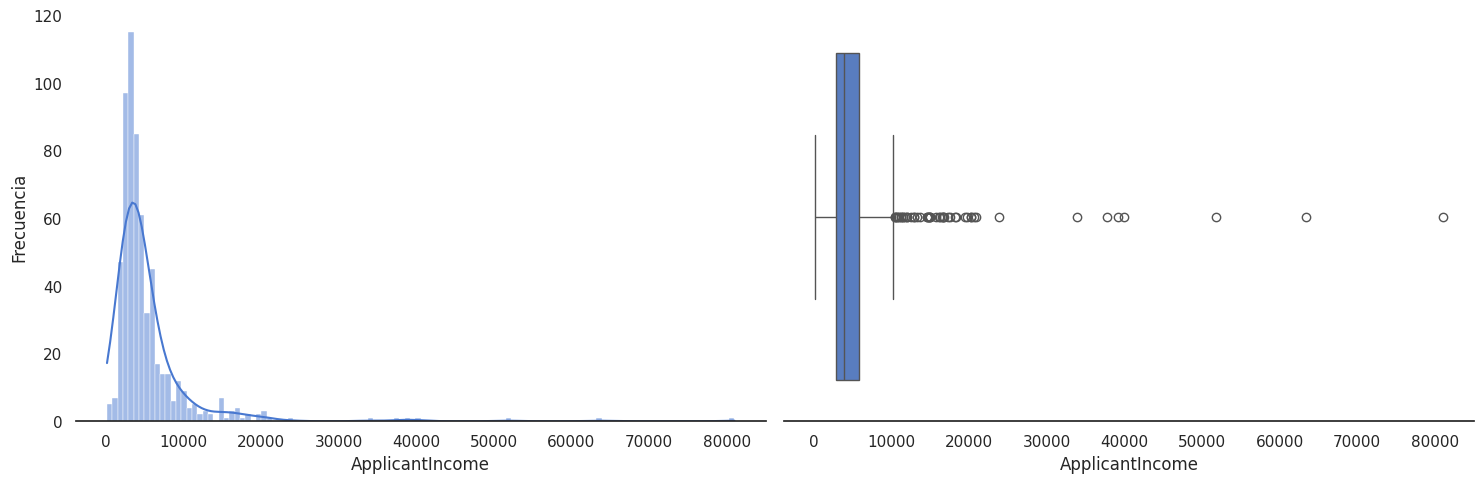

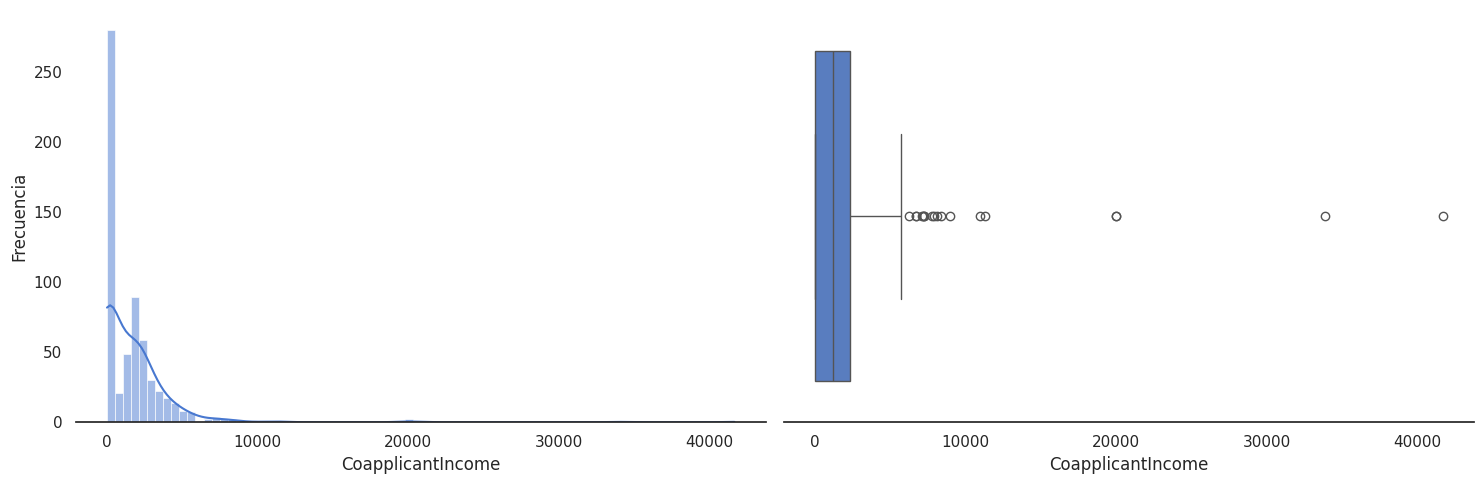

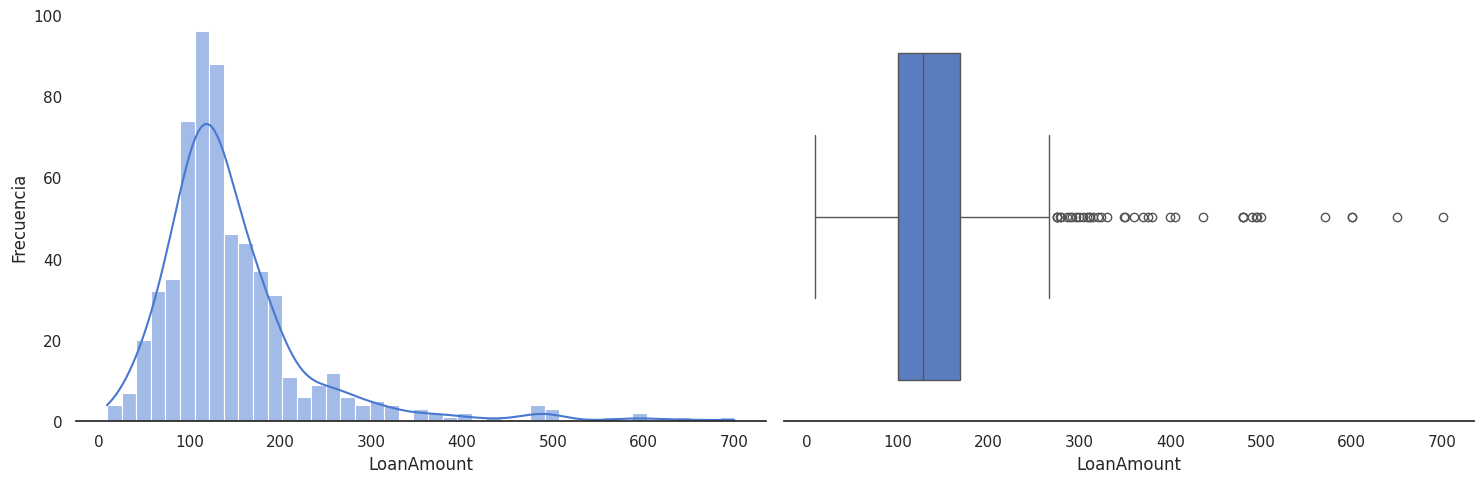

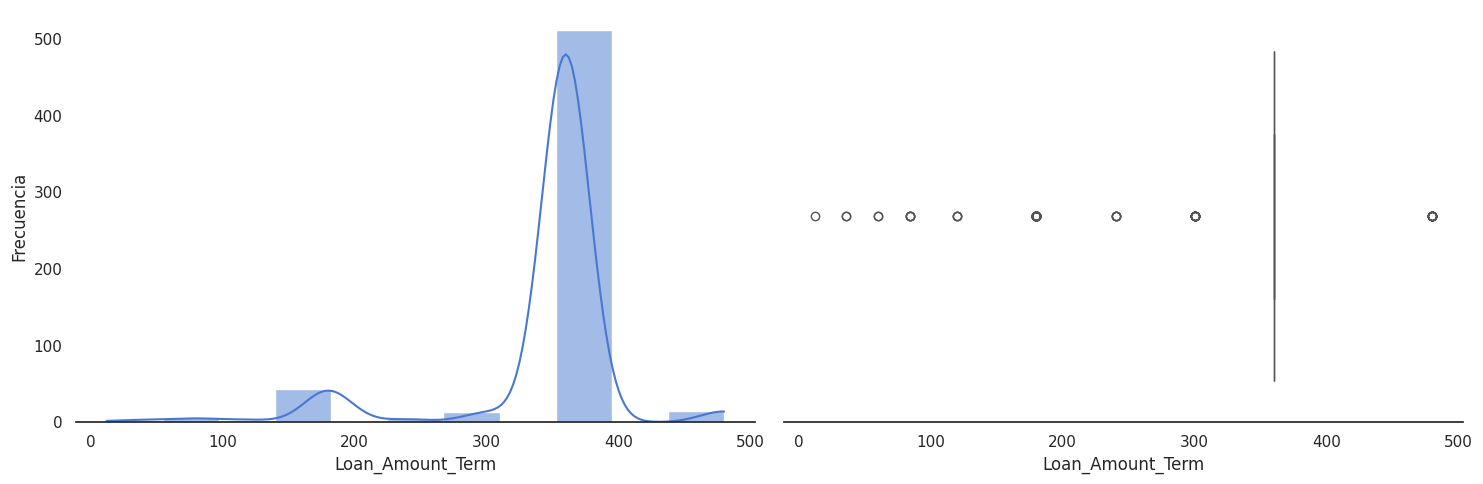

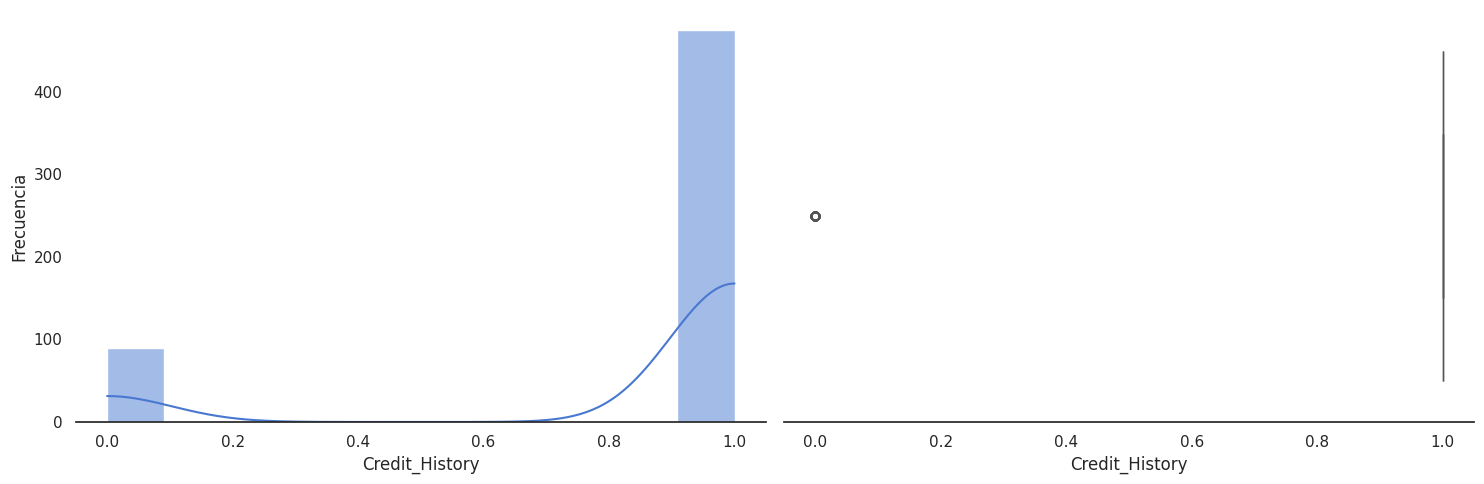

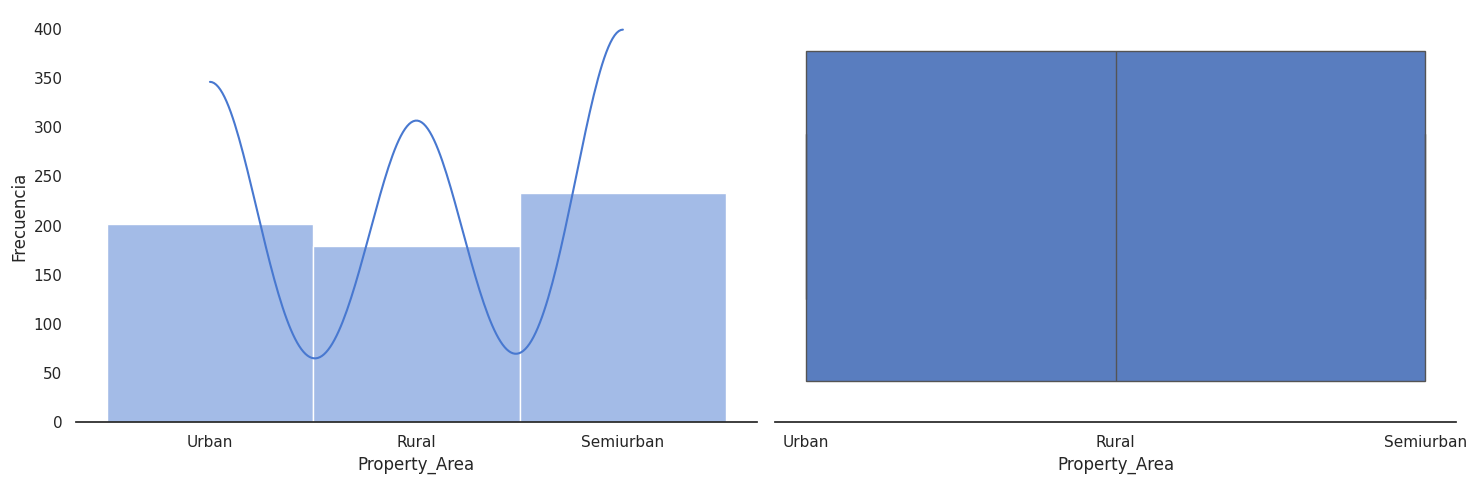

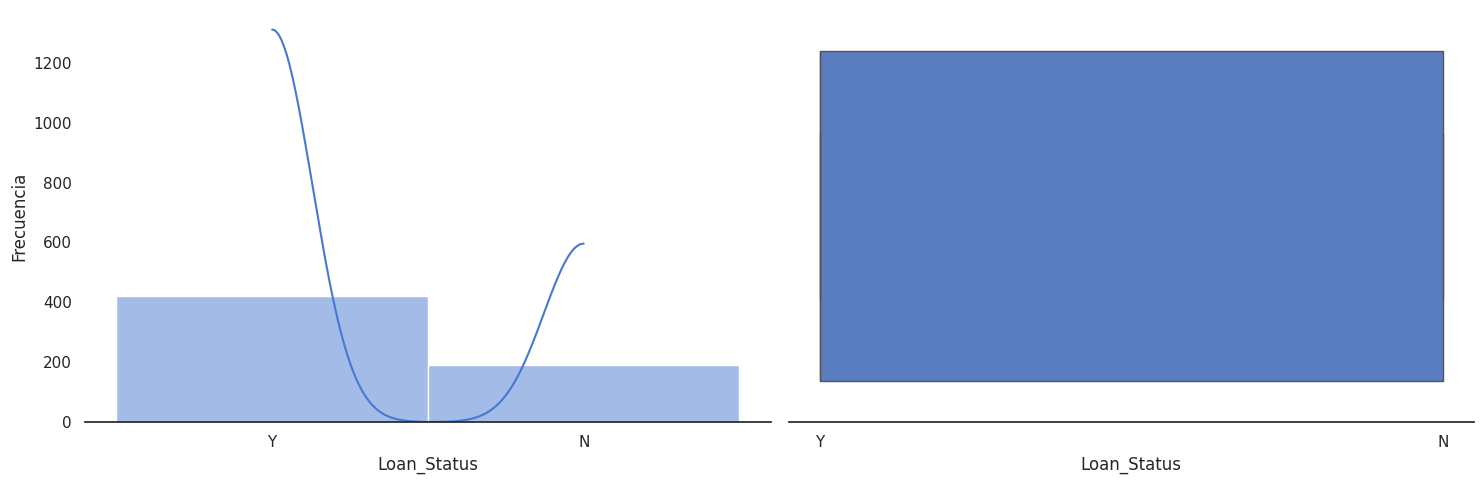

In [22]:
def vis_hist_boxplot(df):
    for i in df.columns:
        fig, ax = plt.subplots(figsize=(15, 5), nrows=1, ncols=2)
        sns.set(style="white", palette="muted", color_codes=True)
        sns.despine(left=True)

        # Histograma con kde
        sns.histplot(data=df, x=i, kde=True, ax=ax[0]).set_xlabel(f"{i}")
        ax[0].set_ylabel('Frecuencia')
        # Boxplot
        sns.boxplot(data=df, x=i, ax=ax[1])

        plt.tight_layout()
        plt.show()

vis_hist_boxplot(df)

## 2) Visualizaciones:
- Crear histogramas y gráficos de barras para entender la distribución de las variables.
- Crear un mapa de calor para visualizar las correlaciones entre las variables.
- Utilizar gráficos de dispersión para identificar posibles relaciones entre las variables.



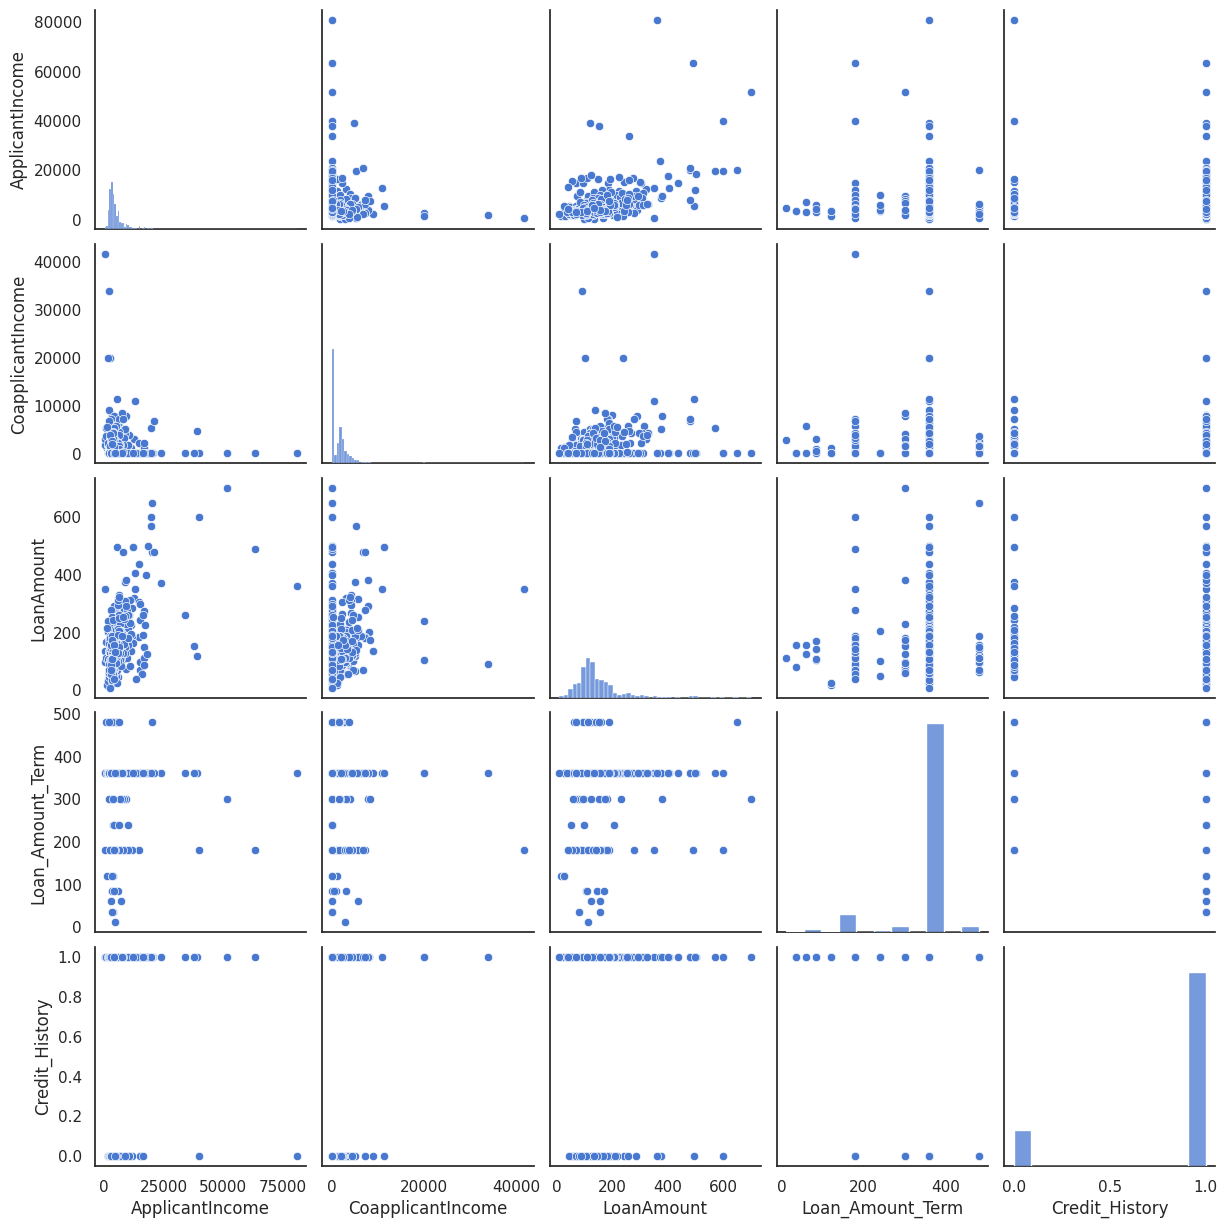

In [23]:
sns.pairplot(df)

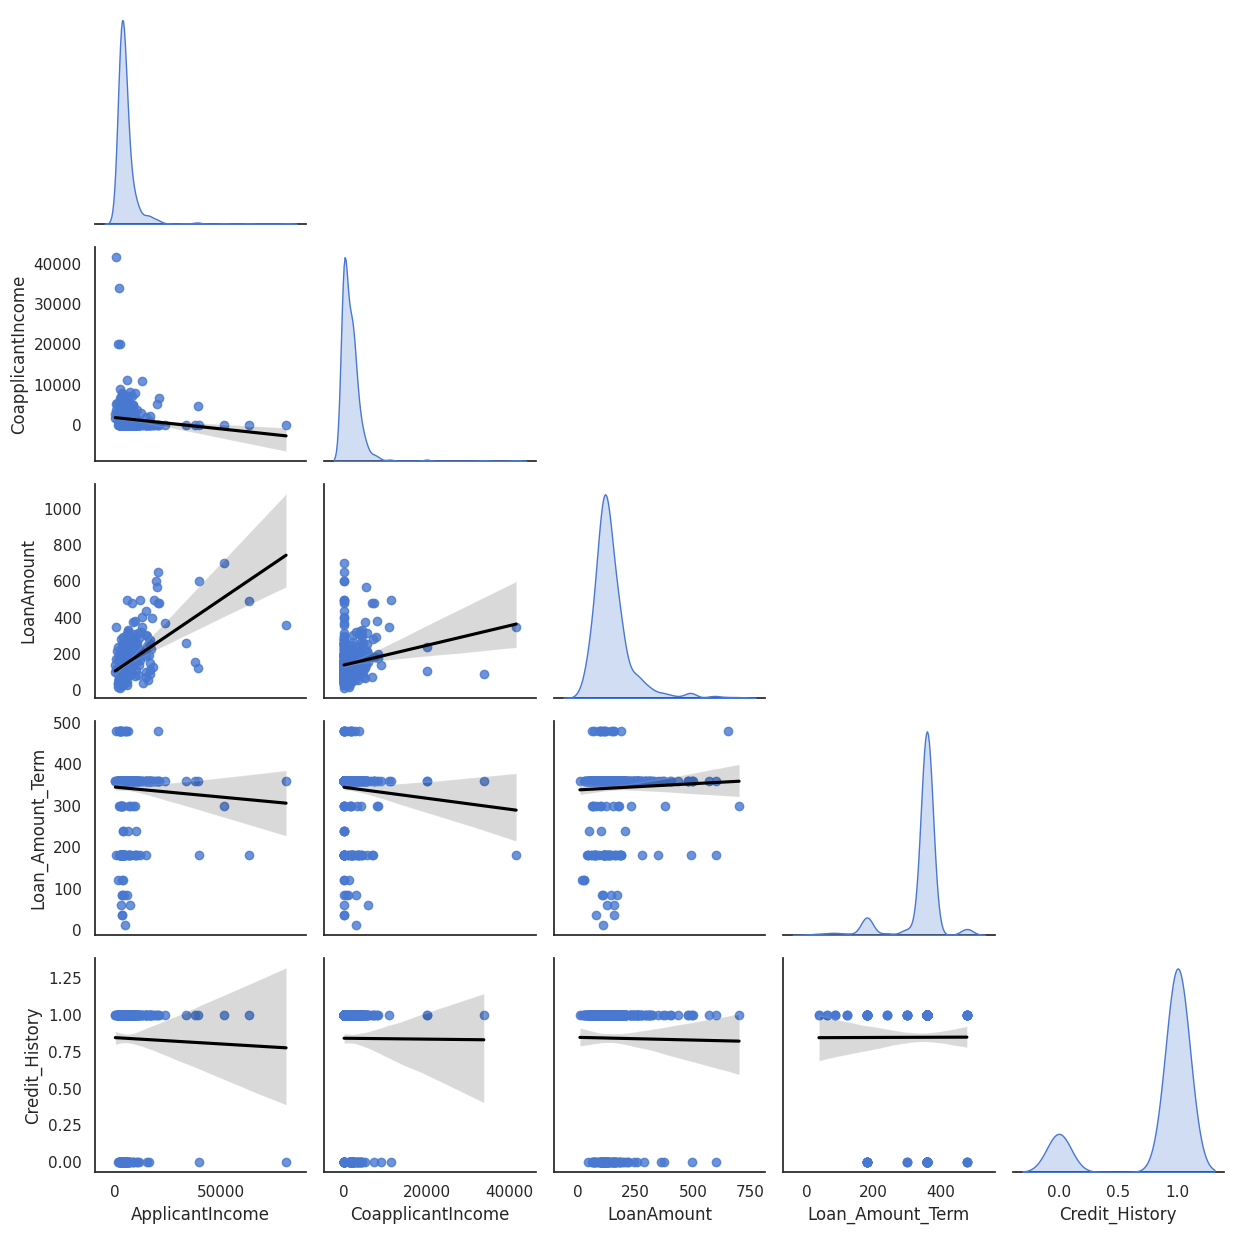

In [24]:
sns.pairplot(df, kind="reg",diag_kind='kde',plot_kws={'line_kws':{'color':'black'}},corner=True)
plt.tight_layout()
plt.show()

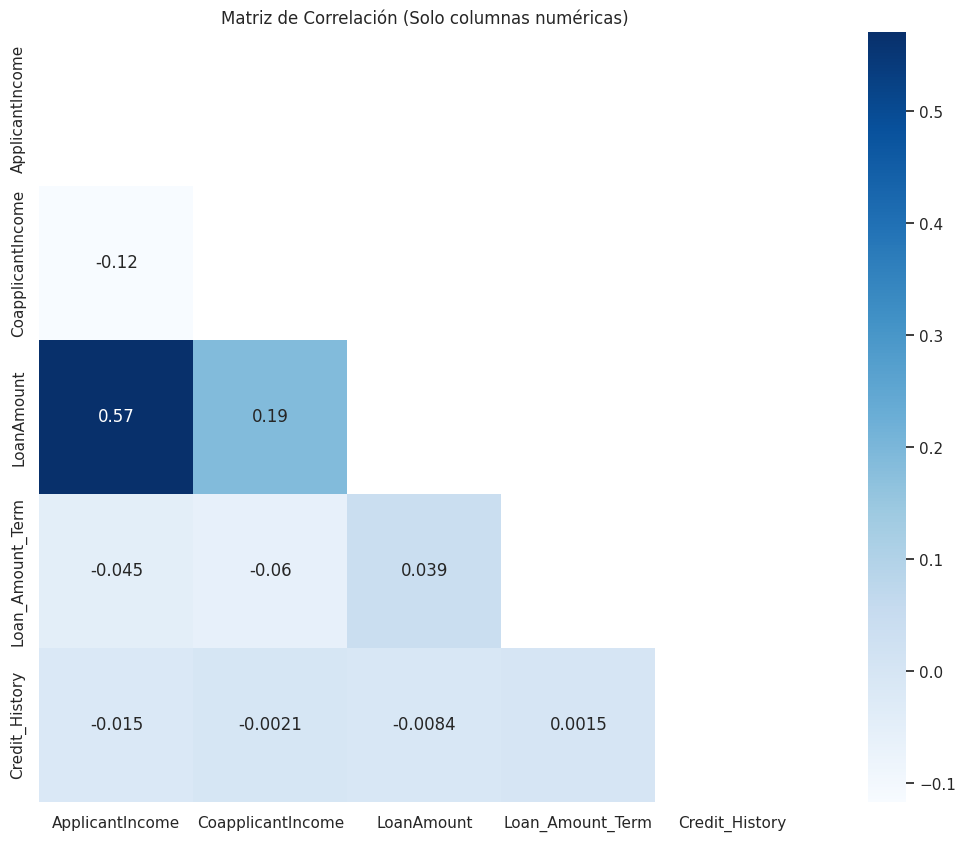

In [25]:
# Filtrar solo las columnas numéricas
df_numeric = df.select_dtypes(include=[np.number])

# Crear una máscara para ocultar la parte superior del triángulo
mask = np.zeros_like(df_numeric.corr())
tri_ind = np.triu_indices_from(mask)
mask[tri_ind] = True

# Configurar el tamaño de la figura y graficar el heatmap
plt.figure(figsize=[15, 10])
sns.heatmap(data=df_numeric.corr(), annot=True, mask=mask, cmap='Blues', square=True)
plt.title('Matriz de Correlación (Solo columnas numéricas)')
plt.show()

In [26]:
# Esto es código de Claude
from scipy.stats import chi2_contingency
import numpy as np

def cramers_v(var1, var2):
    crosstab = pd.crosstab(var1, var2)
    chi2 = chi2_contingency(crosstab)[0]
    n = crosstab.sum().sum()
    min_dim = min(crosstab.shape) - 1
    return np.sqrt(chi2 / (n * min_dim))

# Seleccionar todas las columnas categóricas excepto la variable objetivo
target_col = 'Loan_Status'
categorical_cols = df.select_dtypes(include=['object','int','float']).columns
other_cols = [col for col in categorical_cols if col != target_col]

# Calcular V de Cramer para cada columna con respecto a Loan_Status
cramer_scores = {}
for col in other_cols:
    cramer_scores[col] = cramers_v(df[target_col], df[col])

# Convertir a Series y ordenar
cramer_results = pd.Series(cramer_scores).sort_values(ascending=False)

print(f"\nAsociaciones con {target_col} usando V de Cramer:")
print(cramer_results)

# V de Cramer: medida estadística evalúa fuerza de asociación entre variables categóricas, basada en estadística chi-cuadrado.
# Sus valores van de 0 a 1, donde: 0 significa que no hay asociación, 1 significa una asociación perfecta…
# < 0.1: asociación muy débil, 0.1 - 0.3: asociación débil, 0.3 - 0.5: asociación moderada, >0.5: asociación fuerte

# La ventaja del V de Cramer es que:
# Funciona con variables categóricas de cualquier número de categorías
# Es simétrica (el orden de las variables no importa)
# Es normalizada (siempre va de 0 a 1)
# No asume ninguna distribución específica de los datos


Asociaciones con Loan_Status usando V de Cramer:
Loan_ID              1.000000
ApplicantIncome      0.910812
CoapplicantIncome    0.676651
LoanAmount           0.587492
Credit_History       0.556454
Loan_Amount_Term     0.152824
Property_Area        0.141523
Married              0.085581
Education            0.081631
Dependents           0.072613
Gender               0.015242
Self_Employed        0.000000
dtype: float64


## 3) Valores Faltantes y Outliers:
- Detectar y tratar valores faltantes.
- Identificar y manejar outliers.

In [34]:
# Eliminar la columna 'Loan_ID'
df = df.drop('Loan_ID', axis=1)

In [35]:
# Eliminar filas con al menos un valor nulo
df_no_nulls = df.dropna()

# Imprimir la forma del DataFrame resultante para verificar
df_no_nulls.shape

(480, 12)

In [37]:
# Imputar valores nulos con KNN
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder

# Codificar las variables categóricas
label_encoders = {}  # Para guardar los encoders de cada columna categórica

for col in df.select_dtypes(include=["object"]).columns:
    le = LabelEncoder()
    df[col] = df[col].astype(str)  # Asegurarse de que todo sea string
    df[col] = le.fit_transform(df[col].fillna("missing"))  # Codificar incluyendo 'missing'
    label_encoders[col] = le

print("\nDespués de codificar:")
print(df)

# Configurar instancia
imputer = KNNImputer(n_neighbors=3, weights="uniform")

# Imputar valores faltantes con KNN
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# Redondear columnas categóricas porque el imputador puede producir valores continuos
for col in df.select_dtypes(include=["object"]).columns:
    df_imputed[col] = df_imputed[col].round().astype(int)

print("\nDespués de la imputación:")
print(df_imputed)

# Decodificar las variables categóricas
for col, le in label_encoders.items():
    df_imputed[col] = le.inverse_transform(df_imputed[col].astype(int))

print("\nDespués de decodificar:")
print(df_imputed)


Después de codificar:
     Gender  Married  Dependents  Education  Self_Employed  ApplicantIncome  \
0         1        0           0          0              0             5849   
1         1        1           1          0              0             4583   
2         1        1           0          0              1             3000   
3         1        1           0          1              0             2583   
4         1        0           0          0              0             6000   
..      ...      ...         ...        ...            ...              ...   
609       0        0           0          0              0             2900   
610       1        1           3          0              0             4106   
611       1        1           1          0              0             8072   
612       1        1           2          0              0             7583   
613       0        0           0          0              1             4583   

     CoapplicantIncome  Loan

In [38]:
print("Valores nulos df_no_nulls:")
print(df_no_nulls.isnull().sum() * 100 / len(df))

Valores nulos df_no_nulls:
Gender               0.0
Married              0.0
Dependents           0.0
Education            0.0
Self_Employed        0.0
ApplicantIncome      0.0
CoapplicantIncome    0.0
LoanAmount           0.0
Loan_Amount_Term     0.0
Credit_History       0.0
Property_Area        0.0
Loan_Status          0.0
dtype: float64


In [39]:
print("Valores nulos df_imputed:")
print(df_imputed.isnull().sum() * 100 / len(df))

Valores nulos df_imputed:
Gender               0.0
Married              0.0
Dependents           0.0
Education            0.0
Self_Employed        0.0
ApplicantIncome      0.0
CoapplicantIncome    0.0
LoanAmount           0.0
Loan_Amount_Term     0.0
Credit_History       0.0
Property_Area        0.0
Loan_Status          0.0
dtype: float64


In [40]:
outliers_IQR(df_no_nulls.select_dtypes(include=['int', 'float']))


🚩 Outliers detected in ApplicantIncome: 40

🚩 Outliers detected in CoapplicantIncome: 17

🚩 Outliers detected in LoanAmount: 27

🚩 Outliers detected in Loan_Amount_Term: 69

🚩 Outliers detected in Credit_History: 70


In [41]:
outliers_IQR(df_imputed.select_dtypes(include=['int', 'float']))


🚩 Outliers detected in ApplicantIncome: 50

🚩 Outliers detected in CoapplicantIncome: 18

🚩 Outliers detected in LoanAmount: 41

🚩 Outliers detected in Loan_Amount_Term: 94

🚩 Outliers detected in Credit_History: 107


In [42]:
# Guardar las columnas con outliers en una variable
outlier_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term','Credit_History']

# Aplicar transformaciones logarítmicas y cuadráticas
for col in outlier_cols:
    # Transformación logarítmica
    df_no_nulls[f'{col}_log'] = np.log1p(df_no_nulls[col])  # log(1+x) para evitar errores con 0

    # Transformación cuadrática
    df_no_nulls[f'{col}_squared'] = np.sqrt(df_no_nulls[col])

<ipython-input-42-b2470d9200b4>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_nulls[f'{col}_log'] = np.log1p(df_no_nulls[col])  # log(1+x) para evitar errores con 0
<ipython-input-42-b2470d9200b4>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_nulls[f'{col}_squared'] = np.sqrt(df_no_nulls[col])
<ipython-input-42-b2470d9200b4>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

In [43]:
# Guardar las columnas con outliers en una variable
outlier_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term','Credit_History']

# Aplicar transformaciones logarítmicas y cuadráticas
for col in outlier_cols:
    # Transformación logarítmica
    df_imputed[f'{col}_log'] = np.log1p(df_imputed[col])  # log(1+x) para evitar errores con 0

    # Transformación cuadrática
    df_imputed[f'{col}_squared'] = np.sqrt(df_imputed[col])

In [44]:
outliers_IQR(df_no_nulls.select_dtypes(include=['int', 'float']))


🚩 Outliers detected in ApplicantIncome: 40

🚩 Outliers detected in CoapplicantIncome: 17

🚩 Outliers detected in LoanAmount: 27

🚩 Outliers detected in Loan_Amount_Term: 69

🚩 Outliers detected in Credit_History: 70

🚩 Outliers detected in ApplicantIncome_log: 15

🚩 Outliers detected in ApplicantIncome_squared: 29

🚩 Outliers detected in CoapplicantIncome_log: 0

🚩 Outliers detected in CoapplicantIncome_squared: 3

🚩 Outliers detected in LoanAmount_log: 25

🚩 Outliers detected in LoanAmount_squared: 24

🚩 Outliers detected in Loan_Amount_Term_log: 69

🚩 Outliers detected in Loan_Amount_Term_squared: 69

🚩 Outliers detected in Credit_History_log: 70

🚩 Outliers detected in Credit_History_squared: 70


In [45]:
outliers_IQR(df_imputed.select_dtypes(include=['int', 'float']))


🚩 Outliers detected in ApplicantIncome: 50

🚩 Outliers detected in CoapplicantIncome: 18

🚩 Outliers detected in LoanAmount: 41

🚩 Outliers detected in Loan_Amount_Term: 94

🚩 Outliers detected in Credit_History: 107

🚩 Outliers detected in ApplicantIncome_log: 27

🚩 Outliers detected in ApplicantIncome_squared: 39

🚩 Outliers detected in CoapplicantIncome_log: 0

🚩 Outliers detected in CoapplicantIncome_squared: 4

🚩 Outliers detected in LoanAmount_log: 38

🚩 Outliers detected in LoanAmount_squared: 38

🚩 Outliers detected in Loan_Amount_Term_log: 94

🚩 Outliers detected in Loan_Amount_Term_squared: 94

🚩 Outliers detected in Credit_History_log: 107

🚩 Outliers detected in Credit_History_squared: 107


In [46]:
# prompt: seleccionar las columnas que como si no se hubieran hecho las trasnformaciones en cada df

# Access the original columns from df_no_nulls and df_imputed
original_columns_no_nulls = df_no_nulls.loc[:, ~df_no_nulls.columns.str.endswith(('_log', '_squared'))]
original_columns_imputed = df_imputed.loc[:, ~df_imputed.columns.str.endswith(('_log', '_squared'))]

print("Original columns (df_no_nulls):")
print(original_columns_no_nulls.head())

print("\nOriginal columns (df_imputed):")
print(original_columns_imputed.head())

Original columns (df_no_nulls):
  Gender Married Dependents     Education Self_Employed  ApplicantIncome  \
1   Male     Yes          1      Graduate            No             4583   
2   Male     Yes          0      Graduate           Yes             3000   
3   Male     Yes          0  Not Graduate            No             2583   
4   Male      No          0      Graduate            No             6000   
5   Male     Yes          2      Graduate           Yes             5417   

   CoapplicantIncome  LoanAmount  Loan_Amount_Term  Credit_History  \
1             1508.0       128.0             360.0             1.0   
2                0.0        66.0             360.0             1.0   
3             2358.0       120.0             360.0             1.0   
4                0.0       141.0             360.0             1.0   
5             4196.0       267.0             360.0             1.0   

  Property_Area Loan_Status  
1         Rural           N  
2         Urban           Y  


In [47]:
df_no_nulls = original_columns_no_nulls.copy()
df_imputed = original_columns_imputed.copy()

In [48]:
print("df_no_nulls:")
print(df_no_nulls.shape)
print("\ndf_imputed:")
print(df_imputed.shape)

df_no_nulls:
(480, 12)

df_imputed:
(614, 12)


In [56]:
# Detectar y eliminar outliers en columnas numéricas usando IQR
def outliers_IQR_remove(df):
    # Seleccionar columnas numéricas
    #num_cols = df.select_dtypes(include=['number']).columns

    for col in df:
        Q1 = df[col].quantile(0.25)  # Primer cuartil
        Q3 = df[col].quantile(0.75)  # Tercer cuartil
        IQR = Q3 - Q1               # Rango intercuartílico

        # Definir límites inferior y superior para los valores atípicos
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Identificar y contar outliers
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        print(f"\n🚩 Outliers detected in '{col}': {outliers.shape[0]}")

        # Eliminar los outliers del DataFrame
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

    # Retornar el DataFrame actualizado
    return df

In [61]:
df_no_nulls_r = outliers_IQR_remove(df_no_nulls.select_dtypes(include=['int', 'float']))


🚩 Outliers detected in 'ApplicantIncome': 40

🚩 Outliers detected in 'CoapplicantIncome': 14

🚩 Outliers detected in 'LoanAmount': 21

🚩 Outliers detected in 'Loan_Amount_Term': 62

🚩 Outliers detected in 'Credit_History': 44


In [62]:
df_imputed_r = outliers_IQR_remove(df_imputed.select_dtypes(include=['int', 'float']))


🚩 Outliers detected in 'ApplicantIncome': 50

🚩 Outliers detected in 'CoapplicantIncome': 16

🚩 Outliers detected in 'LoanAmount': 24

🚩 Outliers detected in 'Loan_Amount_Term': 82

🚩 Outliers detected in 'Credit_History': 70


In [66]:
print("df_no_nulls:")
print(df_no_nulls.shape)
print(df_no_nulls_r.shape)
print("\ndf_imputed:")
print(df_imputed.shape)
print(df_imputed_r.shape)

df_no_nulls:
(480, 12)
(299, 5)

df_imputed:
(614, 12)
(372, 5)


### Análisis:
-	Si bien la mayoría de las variables son categóricas, por alguna razón en algunas se ven outliers, en algunas numéricas se ven los outliers, y con la distribución que si bien tiende a ser normal en la mayoría de las variables, hay un sesgo marcado hacía la derecha (por los outliers), lo cual también sugeriría la transformación a usar para el tratamiento de los outliers

-	Al ver la correlación de las variables numéricas LoanAmount se ve que tiene alguna correlación con ApplicantIncome y CoapplicantIncome, algo que, cuando se revisa con la medida de Cramer para ver asociación de las variables con la variable objetivo (Loan_Status), son las mismas variables las que tienen altos valores en la escala de 0 a 1, seguido de LoanAmount, Credit_History, Loan_Amount_Term, Property_Area, se consideran solo aquellas que son mayores a 0.1

-	Se eliminó la columna Loan_ID, y se trabajará con dos df, uno con los datos nulos eliminados, y otro con los datos nulos imputados con KNN, para este segundo se debió codificar todas las variables tipo object y hacer la imputación y después hacer la decodificación para tener el df “con los valores reales” y se verificó nuevamente los datos nulos, confirmando que ya no habían

-	En el caso de los outliers, se trataron dos transformaciones, pero dados los resultados y que en algunas variables no se ve alguna diferencia, lo mejor fue o dejar los datos así, o eliminar los outliers (aunque se reduce bastante la cantidad de entradas), así que se dejaron 4 datasets para evaluarlos en el modelo de una manera inicial y si bien revisar si evaluar con hiperparámetros optimizados o no todos los 4 datasets


# Parte 3: Preprocesamiento de Datos



## 1) Transformación de Columnas:
- Codificar variables categóricas utilizando One-Hot Encoding.
- Escalar características numéricas utilizando StandardScaler.



In [90]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

# DataFrame a procesar
df = df_no_nulls.copy()
#df = df_no_nulls_r.copy()
#df = df_imputed.copy()
#df = df_imputed_r.copy()


# Columna a excluir
exclude_column = 'Loan_Status'

# Identificar columnas categóricas y numéricas
categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_columns = df.select_dtypes(include=['number']).columns.tolist()

# Excluir la columna específica de ambas listas si está presente
if exclude_column in categorical_columns:
    categorical_columns.remove(exclude_column)
if exclude_column in numerical_columns:
    numerical_columns.remove(exclude_column)

# Crear un ColumnTransformer para aplicar diferentes transformaciones
transformer = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(sparse_output=False), categorical_columns),  # One-Hot Encoding para categóricas
        ('scaler', StandardScaler(), numerical_columns)  # Estandarización para numéricas
    ],
    remainder='passthrough'  # Dejar la columna excluida sin transformar
)

# Crear un pipeline
pipeline = Pipeline([
    ('preprocessor', transformer)  # Paso de preprocesamiento
])

# Ajustar y transformar los datos
transformed_array = pipeline.fit_transform(df)

# Obtener los nombres de las columnas transformadas
ohe_feature_names = transformer.named_transformers_['ohe'].get_feature_names_out(categorical_columns)
final_column_names = list(ohe_feature_names) + numerical_columns + [exclude_column]

# Crear un DataFrame con los datos transformados
df_f = pd.DataFrame(transformed_array, columns=final_column_names)

print(df_f)


    Gender_Female Gender_Male Married_No Married_Yes Dependents_0  \
0             0.0         1.0        0.0         1.0          0.0   
1             0.0         1.0        0.0         1.0          1.0   
2             0.0         1.0        0.0         1.0          1.0   
3             0.0         1.0        1.0         0.0          1.0   
4             0.0         1.0        0.0         1.0          0.0   
..            ...         ...        ...         ...          ...   
475           1.0         0.0        1.0         0.0          1.0   
476           0.0         1.0        0.0         1.0          0.0   
477           0.0         1.0        0.0         1.0          0.0   
478           0.0         1.0        0.0         1.0          0.0   
479           1.0         0.0        1.0         0.0          1.0   

    Dependents_1 Dependents_2 Dependents_3+ Education_Graduate  \
0            1.0          0.0           0.0                1.0   
1            0.0          0.0          

## 2) División del Conjunto de Datos:
- Dividir el dataset en conjuntos de entrenamiento y prueba.

In [70]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Ahora dividimos las variables dependientes (target) y explicativas (features)
X = df_f.drop(columns='Loan_Status')  # Variables predictoras
y = df_f['Loan_Status']  # Variable dependiente

# Codificar las etiquetas categóricas de y para que algunos modelos no generen error
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Separar en conjunto de entrenamiento y conjunto de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

### Análisis:
-	Se hizo la transformación de columnas solicitadas y se dividieron los conjuntos de datos

# Parte 4: Implementación de LightGBM (LGBM)



In [71]:
!pip install lightgbm

## 1) Entrenamiento del Modelo:
- Entrenar un modelo de LGBM con hiperparámetros básicos.
- Evaluar el modelo utilizando métricas de rendimiento como la exactitud, precisión, recall, F1-Score y ROC-AUC.



[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 264, number of negative: 120
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 327
[LightGBM] [Info] Number of data points in the train set: 384, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.687500 -> initscore=0.788457
[LightGBM] [Info] Start training from score 0.788457
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

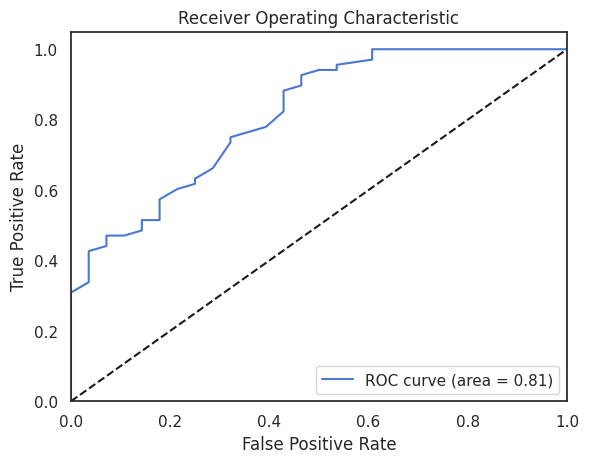

In [87]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Crear el modelo LightGBM
model = lgb.LGBMClassifier(random_state=42)

# Entrenar el modelo
model.fit(X_train, y_train)

# LGBM no admite tipos de datos object, si bien son números, están como texto, así que se necesita convertir
X_test = X_test.astype(float)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print("\n")
print(f'Exactitud: {accuracy}')
print('Informe de Clasificación:')
print(classification_report(y_test, y_pred))

# Matriz de Confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print("\n")
print('Matriz de Confusión:')
print("0: No, 1: Sí")
print(conf_matrix)
print("\n")

# Curva ROC y AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)

# Plotear la curva ROC
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Análisis:
- Los resultados corresponden a:

* df que se eliminaron los nulos y se dejaron los outliers (480 datos)


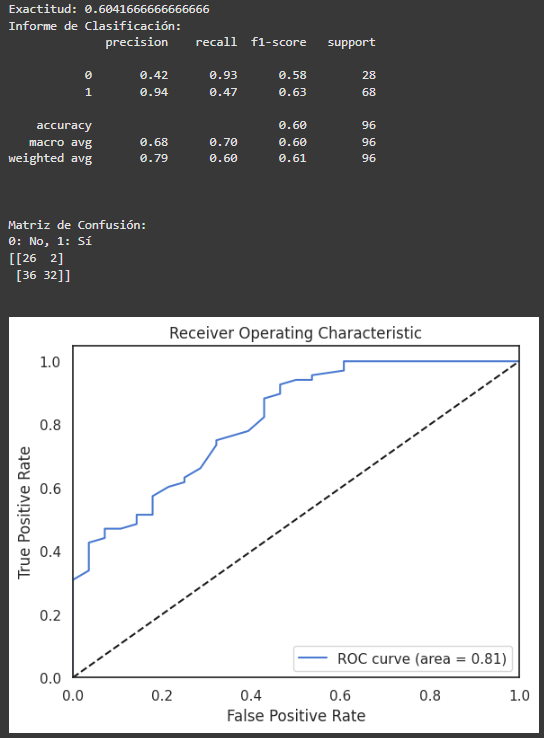

## 2) Optimización de Hiperparámetros:
- Utilizar GridSearchCV para optimizar los hiperparámetros del modelo de LGBM.



## 3) Evaluación del Modelo Optimizado:
- Evaluar el rendimiento del modelo optimizado y compararlo con el modelo inicial.

Fitting 3 folds for each of 729 candidates, totalling 2187 fits


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 264, number of negative: 120
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 327
[LightGBM] [Info] Number of data points in the train set: 384, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.687500 -> initscore=0.788457
[LightGBM] [Info] Start training from score 0.788457
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

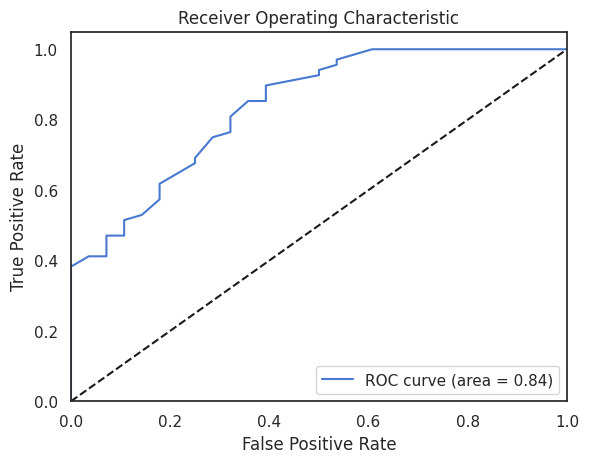

In [91]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Crear el modelo LightGBM
model = lgb.LGBMClassifier(random_state=42)

# Definir los hiperparámetros para la optimización
param_grid = {
    'num_leaves': [31, 50, 100],  # Número de hojas en el árbol
    'learning_rate': [0.01, 0.05, 0.1],  # Tasa de aprendizaje
    'n_estimators': [100, 200, 500],  # Número de árboles
    'max_depth': [-1, 5, 10],  # Profundidad máxima del árbol
    'subsample': [0.7, 0.8, 1.0],  # Fracción de muestras utilizadas para entrenar cada árbol
    'colsample_bytree': [0.7, 0.8, 1.0]  # Fracción de características utilizadas en cada árbol
}

# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)

# Ajustar el modelo con GridSearchCV
grid_search.fit(X_train, y_train)

# Imprimir los mejores parámetros encontrados
print(f"Mejores parámetros: {grid_search.best_params_}")

# Usar el mejor modelo encontrado para hacer predicciones
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

# Evaluar el modelo optimizado
accuracy = accuracy_score(y_test, y_pred)
print("\n")
print(f'Exactitud: {accuracy}')
print('Informe de Clasificación:')
print(classification_report(y_test, y_pred))

# Matriz de Confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print("\n")
print('Matriz de Confusión:')
print("0: No, 1: Sí")
print(conf_matrix)
print("\n")

# Curva ROC y AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)

# Plotear la curva ROC
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


### Análisis:
- Los resultados corresponden a:

* Resultado después de optimización del modelo

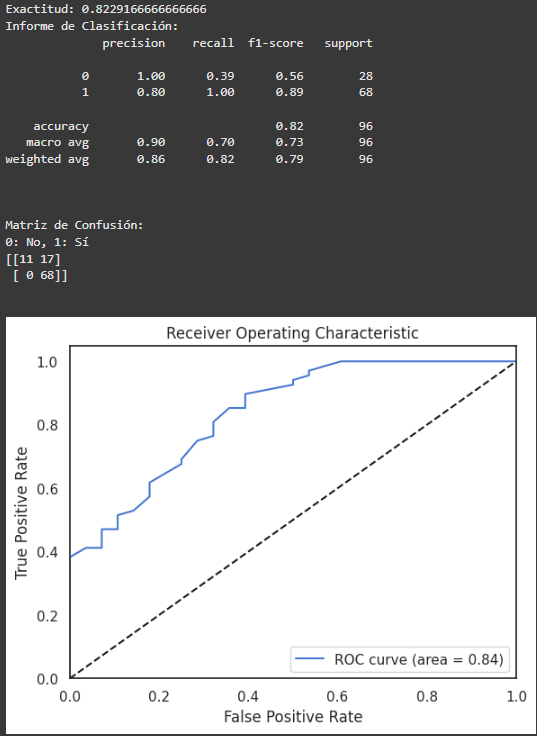

# Conclusión final

El resultado muestra una mejora significativa en la exactitud después de la optimización con GridSearchCV, pasando de un 60.4% a un 82.3%, lo cual es un buen indicativo de que los hiperparámetros optimizados ayudaron a mejorar el rendimiento del modelo.


Sin embargo:
- Precisión:
    - Para la clase 0 (No), la precisión es muy alta (1.00), lo que significa que cuando el modelo predice que es de clase 0, tiene una alta probabilidad de estar en lo cierto.
    - Para la clase 1 (Sí), la precisión es 0.80, lo cual sigue siendo bueno, pero más bajo que para la clase 0.
- Recall:
    - El recall para la clase 0 (No) es muy bajo (0.39), lo que indica que el modelo está perdiendo muchos ejemplos de clase 0 (falsos negativos).
    - Para la clase 1 (Sí), el recall es perfecto (1.00), lo que significa que el modelo detecta todos los ejemplos positivos.

- Matriz de Confusión: Después de la optimización, la matriz de confusión muestra que:
    - Para la clase 0 (No), 11 ejemplos fueron correctamente clasificados, mientras que 17 fueron mal clasificados como clase 1.
    - Para la clase 1 (Sí), todos los 68 ejemplos fueron correctamente clasificados como clase 1.


El modelo ha aprendido a predecir muy bien la clase 1 (Sí), pero ha tenido dificultades para predecir la clase 0 (No). Este comportamiento se refleja en el recall de 0.39 para la clase 0.

Esto sugiere que el modelo podría estar sesgado hacia la clase 1 debido a una desbalanceada distribución de clases en los datos o los parámetros utilizados en el modelo.